# Intensity along the track 

## Dependencies

In [2]:
import astropy.io.fits as fits
from scipy import ndimage
from scipy.optimize import curve_fit, leastsq
from matplotlib import pyplot as plt
import numpy as np
from detectsat.utils.mosaic import *
import imageio as imgio
import math

## Sinus Function

In [3]:
def sinus(angle, ampl, freq, phase_shift, vertical_shift):
    return ampl*np.sin(freq*math.pi*2*angle+phase_shift)+vertical_shift

## Utils Functions 

In [4]:
def createImage(name, array):
    imgio.imwrite(name, array)

In [5]:
def showGraph(array):
    plt.plot(array)
    plt.show()

In [6]:
def createFitsFile(name, array):
    hdu = fits.PrimaryHDU(array)
    hdu.writeto(name+'.fits')

## Add the line on the data

In [7]:
def addLineOnData(line, data, width_line, height_line):
    #For the first block of the fits file (bottom left)
    min_x, min_y = 100, 100
    max_x, max_y = 2000, 4000
    #print(data[min_y:min_y+height_line, min_x:min_x+width_line])
    data[min_y:min_y+height_line, min_x:min_x+width_line] += line[:,:]
    #print('-----------------------')
    #print(data[min_y:min_y+height_line, min_x:min_x+width_line])
    return data

## Find the intensity along the track

In [8]:
def findIntensityAlongTheLine(data, height_line, width_line, start_line_x, start_line_y):
    intensities = []
    for i in range(width_line):
        intensity_for_this_x = 0
        for j in range(height_line):
            intensity_for_this_x += data[start_line_y+j,start_line_x+i]
        intensities.append(intensity_for_this_x)
        #intensities.append(intensity_for_this_x/height_line)



    fig, ax = plt.subplots(1, 2)
    ax = ax.flatten()
    ax[0].plot(intensities)
    ax[0].set_title("Original signal")

    intensities_fft = np.fft.fft(intensities)
    intensities_fft = intensities_fft[:round(width_line/2)]
    intensities_fft = np.abs(intensities_fft)
    intensities_fft = intensities_fft/max(intensities_fft)
    freq_x_axis = np.linspace(0, width_line/2, len(intensities_fft))
    ax[1].plot(freq_x_axis, intensities_fft, "o-")
    ax[1].set_title("Frequency magnitudes")
    ax[1].set_xlabel("Frequency")
    ax[1].set_ylabel("Magnitude")
    plt.grid()
    plt.tight_layout()
    plt.show()

    f_loc = np.argmax(intensities_fft) # Finds the index of the max
    if f_loc == 0:
        intensities_fft[0] = 0
        f_loc = np.argmax(intensities_fft)
    f_val = freq_x_axis[f_loc] # The strongest frequency value
    print(f"The strongest frequency is f = {f_val}")

    guess_mean = np.mean(intensities)
    #guess_std = 3*np.std(intensities)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = f_val/width_line
    guess_amp = 0
    

    x_val = np.arange(width_line)
    showGraph(np.transpose(intensities))
    params, _ = curve_fit(sinus, x_val, intensities, [guess_amp, guess_freq, guess_phase, guess_mean])
    print(params)
    
    plt.scatter(x_val, intensities, label='Data')
    plt.plot(x_val, sinus(x_val, params[0], params[1], params[2], params[3]), color='red', label='Fitted function')
    plt.legend(loc='best')
    plt.show()
    
    
    # we'll use this to plot our first estimate. This might already be good enough for you
    #data_first_guess = guess_std*np.sin(x_val*guess_freq+guess_phase) + guess_mean

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    #optimize_func = lambda x: x[0]*np.sin(x[1]*x_val+x[2]) + x[3] - intensities
    #est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]
    
    # recreate the fitted curve using the optimized parameters

    #fine_t = np.arange(0,max(x_val),0.1)
    #data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

    #plt.plot(x_val, intensities, '.')
    #plt.plot(x_val, data_first_guess, label='first guess')
    #plt.plot(fine_t, data_fit, label='after fitting')
    #plt.legend()
    #plt.show()

    
    #https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    #intensities_fft = np.fft.fft(intensities)
    #intensities_fft = intensities_fft[:round(width_line/2)]
    #intensities_fft = np.abs(intensities_fft)
    #intensities_fft = intensities_fft/max(intensities_fft)

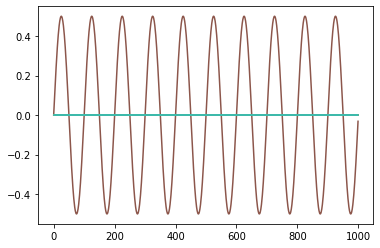

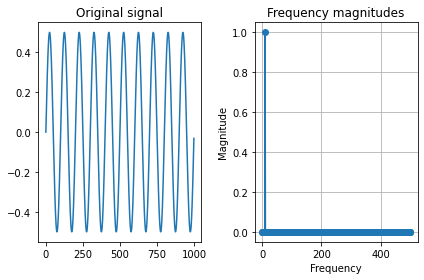

The strongest frequency is f = 10.020040080160319


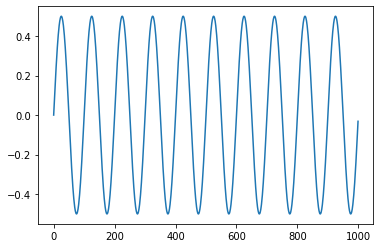

[ 5.00000000e-01  1.00000000e-02 -1.26582134e-08 -1.44909153e-10]


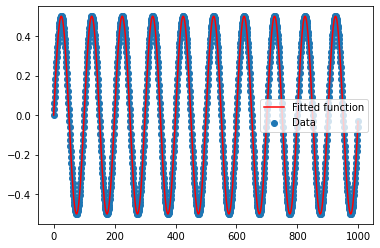

In [9]:
def test_line(): 
    ampl, freq, phase_shift, vertical_shift = 0.5, 0.01, 0, 0
    radius = 15
    width_line = 1000
    height_line = 2*radius
    line = np.zeros((height_line, width_line))
    for i in range(height_line):
        for j in range(width_line):
            if(i == round(height_line/2)):
                line[i,j] = sinus(j, ampl, freq, phase_shift, vertical_shift)
                
    showGraph(np.transpose(line))
    findIntensityAlongTheLine(line, height_line, width_line, 0, 0)
    
test_line()

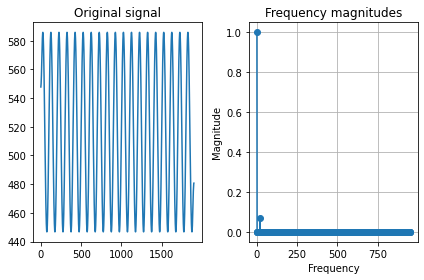

The strongest frequency is f = 19.020021074815595


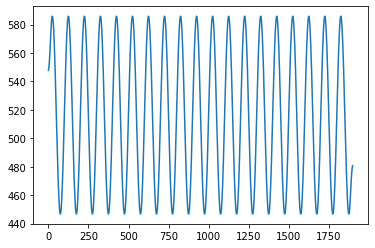

[6.96522234e+01 9.99755291e-03 5.00262337e-02 5.16295969e+02]


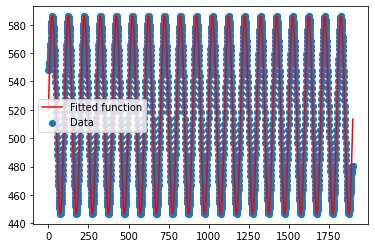

In [60]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
x_star,y_star = 1665,8346
radius = 15
height = 2000
width = 1900
#value = 0.02 #number1
#value = 0.01 #number2
value = 0.008 #number3
#value = 0.008
#ampl, freq, phase_shift, vertical_shift = 0.01, 0.01, 0, 0.5 #number1
#ampl, freq, phase_shift, vertical_shift = 0.05, 0.01, 0, 3 #number2
ampl, freq, phase_shift, vertical_shift = 0.03, 0.01, 0, 2.5 #number3
#ampl, freq, phase_shift, vertical_shift = 0.03, 0.01, 0, 2.5

data = fits.open(name_file)[0].data
star = data[y_star-radius:y_star+radius, x_star-radius:x_star+radius]
height_line = 2*radius
line = np.zeros((height_line, width))

for i in range(height_line):
    for j in range(width):
        if(i == round(height_line/2)):
            #line[i,j] = sinus(j, ampl, period, phase_shift, vertical_shift)
            line[i,j] = value*sinus(j, ampl, freq, phase_shift, vertical_shift)

line_convolved = ndimage.convolve(line, star)
line_convolved[-1,:] = line_convolved[0,:]
#line_convolved[:,:] = line_convolved[:,:]-(51.4*2) #number1
#line_convolved[:,:] = line_convolved[:,:]-(51.4*6) #number2
line_convolved[:,:] = line_convolved[:,:]-(51.4*4) #number3
findIntensityAlongTheLine(line_convolved, height_line, width, 0, 0)
#createImage('line_convolved.png',line_convolved)

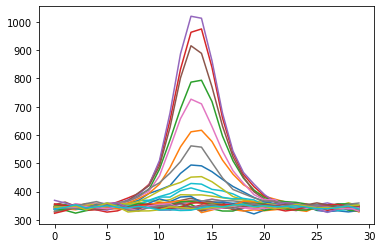

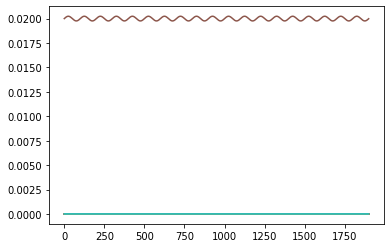

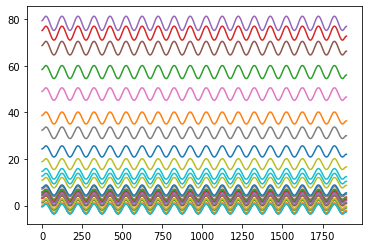

In [61]:
showGraph(np.transpose(star))
showGraph(np.transpose(line))
showGraph(np.transpose(line_convolved))

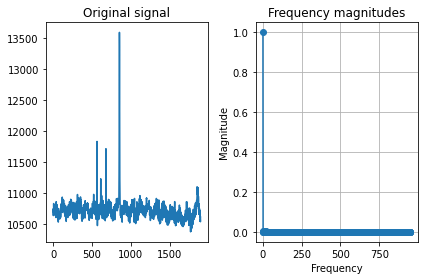

The strongest frequency is f = 19.020021074815595


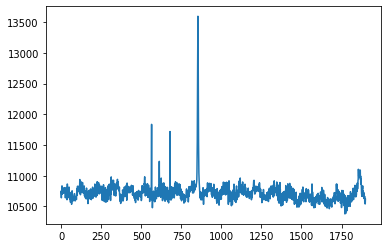

[ 6.22567819e+01  9.93274111e-03 -9.67223746e-02  1.07235555e+04]


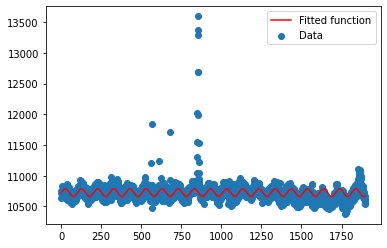

In [62]:
data_with_line = addLineOnData(line_convolved, data, width, height_line)
findIntensityAlongTheLine(data, height_line, width, 100, 100)

In [50]:
scaled_data = scale_image(data_with_line[::-1].copy())
createImage('try_image_line.png', scaled_data)

/Users/noah/Desktop/EPFL/BA6/Projet Bachelor/bachelor-project/detectsat/utils/mosaic.py:51: RuntimeWarning: invalid value encountered in greater
  raw_img[raw_img > z2] = z2
/Users/noah/Desktop/EPFL/BA6/Projet Bachelor/bachelor-project/detectsat/utils/mosaic.py:52: RuntimeWarning: invalid value encountered in less
  raw_img[raw_img < z1] = z1
Lossy conversion from >f8 to uint8. Range [308.9854434077432, 399.347056070591]. Convert image to uint8 prior to saving to suppress this warning.


## Main

In [115]:
def main(args):
    #x_star,y_star = 3274,7977
    #radius = 10
    #x_star,y_star = 2585,7765
    #radius = 5
    #x_star,y_star = 3069,7821
    #x_star,y_star = 1175,7541
    #x_star,y_star = 1639,7812
    x_star,y_star = 1665,8346
    radius = 15
    height = 2000
    width = 1900
    value = 1
    ampl, freq, phase_shift, vertical_shift = 0.5, 0.01, 0, 0.5

    blank_image = np.zeros((height,width))
    data = fits.open(args.i)[0].data
    star = data[y_star-radius:y_star+radius, x_star-radius:x_star+radius]
    height_line = 2*radius
    line = np.zeros((height_line, width))

    for i in range(height_line):
        for j in range(width):
            if(i == round(height_line/2)):
                line[i,j] = sinus(j, ampl, period, phase_shift, vertical_shift)
                #line[i,j] = value*sinus(j, ampl, period, phase_shift, vertical_shift)

    line_convolved = ndimage.convolve(line, star)
    findIntensityAlongTheLine(line, height_line, width, 0, 0)
    #showGraph(np.transpose(line_convolved))
    #Put the same value in the last row as in the first one
    line_convolved[-1,:] = line_convolved[0,:]
    line_convolved[:,:] = line_convolved[:,:]-(51.4*2)
    #createImage('line_convolved_reflect_4r.png', line_convolved)


    #data_with_line = addLineOnData(line_convolved, data, width, height_line)
    #scaled_data = scale_image(data_with_line[::-1].copy())
    #findIntensityAlongTheLine(scaled_data, height_line, width, 100, 100)
    #createImage('try_image_line_new_star_15_04_r.png', scaled_data)


    #createFitsFile(args.i, scaled_data)
    #showGraph(np.transpose(line_convolved))

In [105]:
showGraph(np.transpose(line_convolved))

NameError: name 'line_convolved' is not defined